# Advanced Binary Image Segmentation for the Geo- and Eco-sciences, using Deep Learning

## Case Study: Detecting Intertidal Reefs

#### Daniel Buscombe, MARDA Science

![](https://mardascience.com/wp-content/uploads/2019/06/cropped-MardaScience_logo-5.png)

Before you do anything, go to `File > Save copy in Drive` so you can keep and work on your own copy

## Part 4: Train a oyster reef detector with a class balanced loss function

This jupyter notebook running on Google Colab is part of the "Advanced Binary Image Segmentation for the Geo- and Eco-sciences, using Deep Learning" course. The main course website can be accessed [here](https://mardascience.gitlab.io/binary_image_segmentation_for_geosciences/#/)

In the previous tutorial we made functions to read and pair image and label tiles from this data. In this tutorial, we will start by repeating that process without the visualization steps

Then we will construct, train and evaluate the model. In the [oysterNet paper](https://zslpublications.onlinelibrary.wiley.com/doi/full/10.1002/rse2.134), the authors used a bigger, more sophisticated model for `instance segmentation`, that is, semantic segmentation that is aware of all the different `instances` of the class (i.e. each individual piece of reef). The model they use is called `Mask RCNN`, the implementation of which is [here](https://github.com/matterport/Mask_RCNN). That is a large and very complicated model that is hard to experiment with. The research behind the [oysterNet paper](https://zslpublications.onlinelibrary.wiley.com/doi/full/10.1002/rse2.134) is state-of-the-art.

Here, we use a simpler model with fewer parameters (namely, a residual UNet) and acheive acceptable results for a semantic segmentation (predicting the masks of where the reefs are, rather than by individual instances). The UNet is the same we used in a [previous set of tutorials](https://mardascience.gitlab.io/deep_learning_landscape_classification/#/) and is relatively simple to adapt and play with to demonstrate a few principles.

In the previous tutorial, we started with a basic implementation and got bad results (!) This was on purpose. It demonstrated what you would expect by using an inappropriate loss function for a class imbalanced problem. Class imbalance is probably the norm for binary segmentations, so it's something you need to pay attention to.

**In this tutorial, we will keep everything the same, except use a Dice loss function instead of binary cross-entropy, and we'll keep track of Dice coefficients as metrics**. We'll explains what this means along the way

Then in the next parts, we'll adapt our training strategies, converging toward a more satisfactory result

This is designed to demonstrate a problem-solving strategy, and also a principle that often applies to natural imagery:

> It's not just the model you choose, it's how you train it that counts




### Import libraries

In [0]:
import os #for accessing operating system utilities
from glob import glob #for finding files that match a certain string pattern
import matplotlib.pyplot as plt #for plotting
import numpy as np #for numerical operations
import random, string #for creating random strings
import tensorflow as tf #tensorflow
import json # for reading lable annotations in json format
import requests #for downloading files 
from PIL import Image, ImageFilter #for reading and filtering imagery
import skimage.draw #for making masks (raster label images) from label annotations
from skimage.transform import resize #for resizing imagery
from psutil import virtual_memory #for interrogating our filesystem and RAM specifications
from imageio import imwrite

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from random import shuffle
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate, Conv2DTranspose, Flatten, Activation, Add
from tensorflow.keras.models import Model

### Prepare the data

#### Download the  imagery


For the remainder of the tutorials, we'll be using this version of the data, consisting of imagery and image labels, with an augmented training set consisting of double the original number of imagery, half of which have been augmented with random flips, zoms and rotations

In [0]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    """
    response = filename for input
    destination = filename for output
    """    
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [0]:
file_id = '19RgkzaD9w-rvAF9uBpqMONnwF0lJVPh3'
destination = 'train_images.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf train_images.tar.gz > tmp.txt

In [0]:
file_id = '1gjWGXO7mtBhJuSOqrG6B1inzLF8TfTSX'
destination = 'val_images.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf val_images.tar.gz > tmp.txt

In [0]:
file_id = '1x8HrgEStkBCdBmFNo1xa0x6LCVE2GE1g'
destination = 'train_labels.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf train_labels.tar.gz > tmp.txt

In [0]:
file_id = '1v0kPgwZVQNrGAk0awJi31W83CYvHJbeX'
destination = 'val_labels.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf val_labels.tar.gz > tmp.txt

In [0]:
root = './content/'

Check to see how many images we now have to work with

In [0]:
train_files = glob(root+"1kx1k_dataset/train_images/data/*.png")
val_files = glob(root+"1kx1k_dataset/val_images/data/*.png")

print("# train files: %i" % (len(train_files)))
print("# validation files: %i" % (len(val_files)))

# train files: 1054
# validation files: 130


### Setting up model training

#### Custom batch generator

We are going to feed images to the network in batches. The batch size (number of images and associated labels) will be ...

In [0]:
batch_size = 6

The next function is an image batch generator. A `generator` is a special type of python function that `yields` a set of data. In our case, it will yield a set of `batch_size` images and labels drawn randomly from the entire set of `files` provided

It opens the file, reads it into a numpy array with correct dimensions checked, and then does the same for the label image. It scales the image by dividing by 255, do turn the 8-bit data scaled between 0 and 255 to data scaled between 0 and 1. The labels are flattened from 3D (RGB) to 2D (greyscale integers)

In [0]:
def image_batch_generator(files, sz, batch_size = 4):

  while True: # this is here because it will be called repeatedly by the training function

    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)

    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []

    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images
        raw = Image.open(f)
        raw = raw.resize(sz)
        raw = raw.filter(ImageFilter.UnsharpMask(radius=20, percent=100))
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]

        #get the image dimensions, find the min dimension, then square the image off
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:]

        raw[np.isnan(raw)] = 1e-5 #make any NaNs and InFs a very small number
        raw[np.isinf(raw)] = 1e-5

        batch_x.append(raw)

        #get the masks.
        maskfile = f.replace('_images','_labels').replace('.png','.jpg')
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        try:
           mask = np.max(np.array(mask.resize(sz)),axis=2)
        except:
           mask = np.array(mask.resize(sz))

        # water pixels are always greater than 170
        mask = (mask>170).astype('int') ##170 = (2/3)*255

        mask = mask[:n,:n]

        mask[np.isnan(mask)] = 1e-5
        mask[np.isinf(mask)] = 1e-5
        batch_y.append(mask)

    #preprocess a batch of images and masks
    batch_x = np.array(batch_x) #/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,1) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

Let's test our generator function

We will specify input imagery of size `(512, 512, 3)`

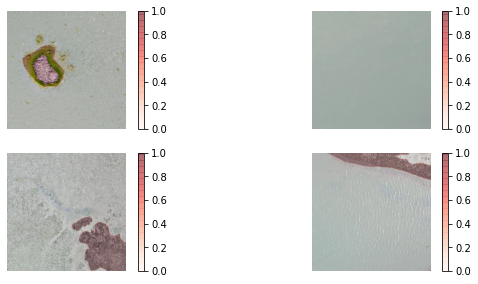

In [0]:
sz = (512, 512)

gen = image_batch_generator(train_files, sz, batch_size = 4)

images, masks = next(gen)

plt.figure(figsize=(10,10))

for k in range(len(images)):
  plt.subplot(4,2, k+1)
  plt.imshow(images[k])
  plt.imshow(masks[k].squeeze(), vmin=0, vmax=1, alpha=0.25, cmap=plt.cm.Reds)
  plt.colorbar()
  plt.axis('off')

#### Build the model

The following definitions are used to make the residual UNet model, which is what we will be using for our binary segmentation

This model is based on one proposed by [Drozdzal et al.](https://arxiv.org/abs/1608.04117). Compared to the original U-Net, we swap out the basic stacked convolution blocks in favor of residual blocks. This residual block introduces short skip connections (within the block) alongside the existing long skip connections (between the corresponding feature maps of encoder and decoder modules) found in the standard U-Net structure. In theory, short skip connections allow for faster convergence when training and allow for deeper models to be trained.

In [0]:
def batchnorm_act(x):
    x = BatchNormalization()(x)
    return Activation("relu")(x)

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = batchnorm_act(x)
    return Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)

def bottleneck_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([conv, bottleneck])

def res_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([bottleneck, res])

def upsamp_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    return Concatenate()([u, xskip])

def res_unet(sz, f):
    inputs = Input(sz)
    
    ## downsample  
    e1 = bottleneck_block(inputs, f); f = int(f*2)
    e2 = res_block(e1, f, strides=2); f = int(f*2)
    e3 = res_block(e2, f, strides=2); f = int(f*2)
    e4 = res_block(e3, f, strides=2); f = int(f*2)
    _ = res_block(e4, f, strides=2)
    
    ## bottleneck
    b0 = conv_block(_, f, strides=1)
    _ = conv_block(b0, f, strides=1)
    
    ## upsample
    _ = upsamp_concat_block(_, e4)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e3)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e2)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e1)
    _ = res_block(_, f)
    
    ## classify
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(_)
    
    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
	

This is a class imbalanced problem, with many more `non-reef` pixels compared to `reef` pixels (the target class)

Last time we used `binary crossentropy` as our loss function. Given two masks $y_{true}, y_{pred}$ we evaluate the loss as:

$$L = \sum{y_{pred}\log(y_{true}) + (1- y_{pred}) \log(1 -y_{true})}$$

Intersection-over-Union (IoU score or Jaccard Index) is another common metric that also performs suboptimally for class imbalanced problems

$$L = \frac{ \left(y_{true} \cap y_{pred} \right)}{y_{true} \cup y_{pred}}$$

The (Sorensen-)Dice loss (a.k.a. "F score") is more suitable for class balanced problems

$$L = \frac{ 2 \left(y_{true} \cap y_{pred} \right)}{\left(y_{true} \cup y_{pred}\right) \left(y_{true} \cap y_{pred} \right)}$$

See more detailed explanations [here](https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou/276144#276144) and [here](https://www.jeremyjordan.me/evaluating-image-segmentation-models/) on the difference IoU and Dice loss functions


In [0]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

This loss function is known as the soft Dice loss because we directly use the predicted probabilities instead of thresholding and converting them into a binary mask.

Next, we make and compile our model

As we saw in lesson 1, model compilation is a necessary step, involving specifiying the 'optimizer' (we will use `rmsprop` but `adam` is also a good one to use, in my experience). The loss function is the Dice loss, and the metric we want to keep track of in the dice coefficient

In [0]:
model = res_unet(sz+(3,), batch_size)
model.compile(optimizer = tf.keras.optimizers.Adam(1e-3), loss = dice_coef_loss, metrics = [dice_coef])

Let's take a look at how many parameters we have to optimize

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 512, 512, 6)  168         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 512, 512, 6)  24          conv2d_30[0][0]                  
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 512, 512, 6)  24          input_2[0][0]                    
____________________________________________________________________________________________

We have over 600,000 trainable parameters. This is a lot, for any model, but tiny compared to the number of parameters in some deep learning models, with up to hundreds of millions of trainable parameters

### Train the model

We can use a custom callback function to see how the model is training while it trains

This must be placed within a class with only one input, `tf.keras.callbacks.Callback`. 

See https://www.tensorflow.org/guide/keras/custom_callback for more details

The following will create a plot, at the end of each training epoch, of the segmentation of one validation image using the current state of the model, while it trains

The plot consists of three images side by side: the validation image, the predicted binary mask, and the masked image showing just that class

The internal function `on_train_begin` allocates some empty lists that are subsequently filled at the end of the epoch, when `on_epoch_end` is called

In [0]:
callbacks = tf.keras.callbacks
backend = tf.keras.backend


class PlotLearning(callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'dice_coef=',logs.get('dice_coef'),'val_dice_coef=',logs.get('val_dice_coef'))

        #choose a random test image and preprocess
        f = np.random.choice(val_files)

        raw = np.array(Image.open(f).resize(sz))

        #predict the mask
        pred = 255*model.predict(np.expand_dims(raw, 0)).squeeze()
        print(np.max(pred))

        #mask post-processing
        msk  = (pred>200).astype('int') #100

        msk = np.stack((msk,)*3, axis=-1)

        #show the mask and the segmented image
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()
        #plt.savefig(str(self.i)+'.png', dpi=100, bbox_inches='tight')

These are parameters that we will pass to callback functions that will adaptively change the pace of training (using an adaptive learning rate), and decide when there is little to be gained from extra training (called 'early stopping')

Reduce loss on plateau: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

Early stopping: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

We'll see that even though the `max_epochs` is set to 200, the model won't need nearly that many epochs


In [0]:
# a tolerance for the training. 
min_delta = 0.0001

# minimum learning rate (lambda)
min_lr = 0.0001

# the factor applied to the learning rate when the appropriate triggers are made
factor = 0.2

# number of epochs without performance improvement before the learning rate is adjusted
# and number of epochs with no improvement after which training will be stopped.
patience=25

#number of epochs to wait before resuming normal operation after the learning rate has been reduced.
cooldown=2

max_epochs = 100

Now we have defined all these hyperparameters (parameters that we chose, not automatically determined by the model), we can make a function that builds all the various callbacks together into a list, which can then be passed to the model training (`.fit()` function)

In [0]:
def build_callbacks(filepath, min_delta, min_lr, factor, patience, cooldown):

    earlystop = EarlyStopping(monitor="val_loss", 
                                  mode="min", patience=patience) 
    
    # reduction of learning rate if and when validation scores plateau upon successive epochs
    reduceloss_plat = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, 
                                    verbose=1, mode='auto', min_delta=min_delta, 
                                    cooldown=cooldown, min_lr=min_lr)

    # set checkpoint file 
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                                   verbose=0, save_best_only=True, mode='min', 
                                   save_weights_only = True)
        
    callbacks = [model_checkpoint, reduceloss_plat, earlystop, PlotLearning()]

    return callbacks 

Next, set up a name for the `.h5` file that will be used to store model weights.

Finally, we train the model by calling the `.fit()` command and providing all the generators and hyperparameters defined in the callbacks

The number of training and validation steps is simply the number of respective files divided by the batch size

In [0]:
filepath = 'reefs_test_weights_uresnet'+str(batch_size)+'_'+str(max_epochs)+'epochs.h5'

train_generator = image_batch_generator(train_files, sz, batch_size = batch_size)
val_generator  = image_batch_generator(val_files, sz, batch_size = batch_size)
train_steps = len(train_files) //batch_size
val_steps = len(val_files) //batch_size
print(train_steps)
print(val_steps)

175
21


If you'd rather not wait the hours it might take to train the model you should leave the following cell uncommented 

In [0]:
file_id = '1LyjyOxuzYzmWrwh6kxPVDZZWEzZGehNq'
destination = 'reefs_test_weights_uresnet6_100epochs.h5'
download_file_from_google_drive(file_id, destination)
model.load_weights(destination)
max_epochs = 5 #just use 5 epochs

Epoch 1/5
175/175 [==============================] - ETA: 0s - loss: 0.1862 - dice_coef: 0.8138i= 1 loss= 0.18620848655700684 val_loss= 0.30256202816963196 dice_coef= 0.8137911558151245 val_dice_coef= 0.6974379420280457
254.99915


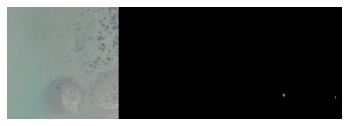

175/175 [==============================] - 145s 826ms/step - loss: 0.1862 - dice_coef: 0.8138 - val_loss: 0.3026 - val_dice_coef: 0.6974 - lr: 0.0010
Epoch 2/5
175/175 [==============================] - ETA: 0s - loss: 0.1855 - dice_coef: 0.8145i= 2 loss= 0.18550486862659454 val_loss= 0.20034676790237427 dice_coef= 0.8144949674606323 val_dice_coef= 0.799653172492981
8.941005e-05


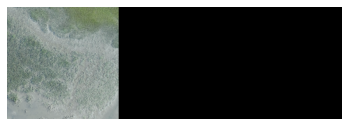

175/175 [==============================] - 144s 821ms/step - loss: 0.1855 - dice_coef: 0.8145 - val_loss: 0.2003 - val_dice_coef: 0.7997 - lr: 0.0010
Epoch 3/5
175/175 [==============================] - ETA: 0s - loss: 0.1757 - dice_coef: 0.8243i= 3 loss= 0.175726518034935 val_loss= 0.20402856171131134 dice_coef= 0.8242737054824829 val_dice_coef= 0.7959713935852051
255.0


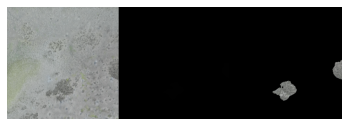

175/175 [==============================] - 143s 820ms/step - loss: 0.1757 - dice_coef: 0.8243 - val_loss: 0.2040 - val_dice_coef: 0.7960 - lr: 0.0010
Epoch 4/5
175/175 [==============================] - ETA: 0s - loss: 0.1706 - dice_coef: 0.8294i= 4 loss= 0.1705811470746994 val_loss= 0.45236989855766296 dice_coef= 0.8294187784194946 val_dice_coef= 0.5476301908493042
20.223482


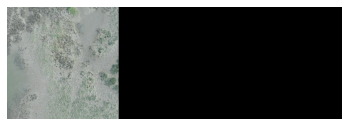

175/175 [==============================] - 145s 828ms/step - loss: 0.1706 - dice_coef: 0.8294 - val_loss: 0.4524 - val_dice_coef: 0.5476 - lr: 0.0010
Epoch 5/5
175/175 [==============================] - ETA: 0s - loss: 0.1981 - dice_coef: 0.8019i= 5 loss= 0.19806045293807983 val_loss= 0.28571459650993347 dice_coef= 0.8019394278526306 val_dice_coef= 0.7142854332923889
255.0


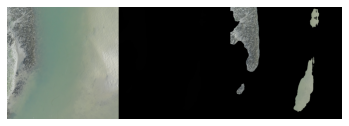

175/175 [==============================] - 144s 820ms/step - loss: 0.1981 - dice_coef: 0.8019 - val_loss: 0.2857 - val_dice_coef: 0.7143 - lr: 0.0010


In [0]:
hist = model.fit(train_generator, 
                epochs = max_epochs, steps_per_epoch = train_steps,
                validation_data = val_generator, validation_steps = val_steps,
                callbacks = build_callbacks(filepath, min_delta, min_lr, factor, patience, cooldown))	

In the above, we gave an output variable to the `.fit()` command. This contains the training histories. That is, losses and metrics as a function of epoch. You can access the variables in the dictionary like so

#### Plot the training history

In [0]:
hist.history.keys()

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef', 'lr'])

Let's make a plot of the histories of both train and validation losses and dice coefficients, and also the history of the learning rate

Text(0, 0.5, 'Learning rate')

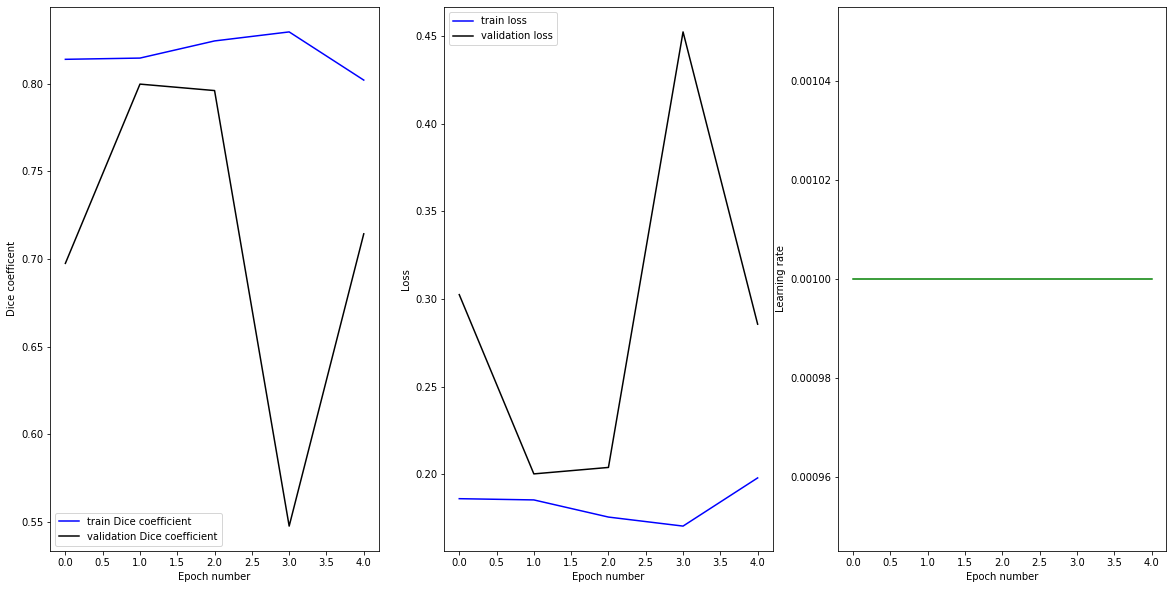

In [0]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.plot(hist.history['dice_coef'], 'b', label='train Dice coefficient')
plt.plot(hist.history['val_dice_coef'], 'k', label='validation Dice coefficient')
plt.xlabel('Epoch number'); plt.ylabel('Dice coefficent')
plt.legend()

plt.subplot(132)
plt.plot(hist.history['loss'], 'b', label='train loss')
plt.plot(hist.history['val_loss'], 'k', label='validation loss')
plt.xlabel('Epoch number'); plt.ylabel('Loss')
plt.legend()

plt.subplot(133)
plt.plot(hist.history['lr'], 'g')
plt.xlabel('Epoch number'); plt.ylabel('Learning rate')

### Test the model

Get the test set of files and untar like we did the other sets

In [0]:
file_id = '1lL6cbUNhwAQsDl4P4LIYiOMOwKxrhq-c'
destination = 'test_images.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf test_images.tar.gz > tmp.txt

In [0]:
file_id = '1GVZgjzuVatp-OjU5s5DJOgAteUvN1yDC'
destination = 'test_labels.tar.gz'
download_file_from_google_drive(file_id, destination)

In [0]:
!tar -xf test_labels.tar.gz > tmp.txt

Get a test generator

In [0]:
test_files = glob(root+"1kx1k_dataset/test_images/*.png")

test_generator = image_batch_generator(test_files, sz, batch_size = batch_size)

print("# test files: %i" % (len(test_files)))

# test files: 163


Use the `.evaluate()` function of the model to get average Dice scores and losses for the test set



In [0]:
# some other training parameters
steps = len(test_files) // batch_size

# testing
scores = model.evaluate(test_generator, steps=steps) 

print('loss={loss:0.4f}, Mean Dice={dice_coef:0.4f}'.format(loss=scores[0], dice_coef=scores[1]))

27/27 [==============================] - 15s 573ms/step - loss: 0.2807 - dice_coef: 0.7193
loss=0.2807, Mean Dice=0.7193


In the [oysterNet paper](https://zslpublications.onlinelibrary.wiley.com/doi/full/10.1002/rse2.134), the authors report a precision of 0.771 and recall of 0.772. The Dice score is mathematically equivalent to the F1 score, the harmonic mean of precision and recall, or ~77%

Here, with a simpler model with fewer parameters, we acheived an average dice score of ~72% ! 

Can we do even better? Let's explore in the next tutorial


This jupyter notebook running on Google Colab is part of the "Advanced Binary Image Segmentation for the Geo- and Eco-sciences, using Deep Learning" course. The main course website can be accessed [here](https://mardascience.gitlab.io/binary_image_segmentation_for_geosciences/#/)